In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial import distance

In [3]:
def load_data(train, test, fname) :
    fpath = "trained_models/resnet18_{}_piecewise_eps8_bs256_maxlr0.1_BNeval/eval/{}/{}.txt".format(train, test, fname)
    return np.loadtxt(fpath).astype(np.int)

train = "autoattack"
test = "pgd"

y_robust = load_data(train, test, "y_robust")
y_robust_pred = load_data(train, test, "y_robust_pred")
y_cross_robust = load_data(train, test, "y_cross_robust")
y_cross_robust_pred = load_data(train, test, "y_cross_robust_pred")

Let :

$Y = \{y_1, y_2, y_3, ... , y_n \}$ -> the original label

$P^{M_C}_{X_B} = \{p_1, p_2, p_3, ... , p_n \}$ -> the prediction of model $M_C$ on $X_B$

$E^{M}_{X_B} = \{id, \quad id \in Y \land id \in P^{M}_{X_B} \land y_{id} \neq p_{id} \}$ -> a list of failed test cases where prediction of the model ${M}$ is incorrect on $X_B$

$E^{M_C}_{X_B} = \{id, \quad id \in Y \land id \in P^{M_C}_{X_B} \land y_{id} \neq p_{id} \}$ -> a list of failed test cases where prediction of the robust ${M_C}$ is wrong for $X_B$

$Difference(List_1, List_2) = \{ id, \quad id \in List_1 \land id \not \in List_2 \}$

$R^C_B = Difference(E^{M}_{X_B}, E^{M_C}_{X_B})$

$R^B_B = Difference(E^{M}_{X_B}, E^{M_B}_{X_B})$

$Intersection(List_2, List_2) = \{ id, \quad id \in List_1 \land id \in List_2 \} $

Inspired from Jaccard simmilarity, we propose BSEM to measure the similarity of bug-attaccking behavior from adversarial attack

$BSEM_{C-fix-B} = \frac{Length(Intersection(R^C_B, R^B_B))}{Length(R^C_B) + Length(R^B_B) - Length(Intersection(R^C_B, R^B_B))}$

$BSEM_{B-fix-C} = \frac{Length(Intersection(R^B_C, R^C_C))}{Length(R^B_C) + Length(R^C_C) - Length(Intersection(R^B_C, R^C_C))}$

$BSEM(B,C) = \frac{BSEM_{B-fix-C} + BSEM_{C-fix-B}}{2}$

Failed Test Cases instead of Robust


In [4]:
def get_robust_data(train, test):
    y_adv = load_data(train, test, "y_cross_robust")
    y_adv_pred = load_data(train, test, "y_cross_robust_pred")
    return y_adv, y_adv_pred

train = "pgd"
test = "autoattack"
y_adv, y_adv_pred = get_robust_data(train, test)

print("Y_adv({},{}): {}".format(train, test, y_adv))
print("Y_adv_pred({},{}): {}".format(train, test, y_adv_pred))

Y_adv(pgd,autoattack): [3 8 8 ... 5 1 7]
Y_adv_pred(pgd,autoattack): [3 8 0 ... 5 1 7]


In [5]:
train = "fgsm"
test = "autopgd"
y_adv, y_adv_pred = get_robust_data(train, test)

print("Y_adv({},{}): {}".format(train, test, y_adv))
print("Y_adv_pred({},{}): {}".format(train, test, y_adv_pred))

Y_adv(fgsm,autopgd): [3 8 8 ... 5 1 7]
Y_adv_pred(fgsm,autopgd): [3 8 8 ... 5 0 7]


In [6]:
attacks = ["autoattack", "autopgd", "bim", "cw", "fgsm", "pgd", "deepfool", "newtonfool", "squareattack", "pixelattack", "spatialtransformation"]

In [7]:
predictions = {}
labels = {}

for a1 in attacks :
    p = np.array([])
    l = np.array([])
    for a2 in attacks :
        y, y_pred = get_robust_data(a1, a2)
        p = np.concatenate((p, y_pred))
        l = np.concatenate((l, y))
    predictions[a1] = p
    labels[a1] = l

In [8]:
predictions

{'autoattack': array([3., 8., 8., ..., 6., 1., 7.]),
 'autopgd': array([3., 8., 8., ..., 6., 1., 7.]),
 'bim': array([3., 8., 1., ..., 5., 1., 6.]),
 'cw': array([3., 8., 8., ..., 6., 1., 2.]),
 'fgsm': array([3., 8., 8., ..., 3., 5., 7.]),
 'pgd': array([3., 8., 0., ..., 6., 0., 7.]),
 'deepfool': array([3., 1., 0., ..., 3., 1., 7.]),
 'newtonfool': array([3., 1., 0., ..., 5., 0., 2.]),
 'squareattack': array([3., 8., 1., ..., 6., 1., 3.]),
 'pixelattack': array([3., 3., 3., ..., 3., 3., 3.]),
 'spatialtransformation': array([5., 8., 2., ..., 5., 1., 7.])}

In [9]:
labels

{'autoattack': array([3., 8., 8., ..., 5., 1., 7.]),
 'autopgd': array([3., 8., 8., ..., 5., 1., 7.]),
 'bim': array([3., 8., 8., ..., 5., 1., 7.]),
 'cw': array([3., 8., 8., ..., 5., 1., 7.]),
 'fgsm': array([3., 8., 8., ..., 5., 1., 7.]),
 'pgd': array([3., 8., 8., ..., 5., 1., 7.]),
 'deepfool': array([3., 8., 8., ..., 5., 1., 7.]),
 'newtonfool': array([3., 8., 8., ..., 5., 1., 7.]),
 'squareattack': array([3., 8., 8., ..., 5., 1., 7.]),
 'pixelattack': array([3., 8., 8., ..., 5., 1., 7.]),
 'spatialtransformation': array([3., 8., 8., ..., 5., 1., 7.])}

In [10]:
accuracies = []
for a in attacks :
    accuracies.append(np.equal(predictions[a], labels[a]))
accuracies

[array([ True,  True,  True, ..., False,  True,  True]),
 array([ True,  True,  True, ..., False,  True,  True]),
 array([ True,  True, False, ...,  True,  True, False]),
 array([ True,  True,  True, ..., False,  True, False]),
 array([ True,  True,  True, ..., False, False,  True]),
 array([ True,  True, False, ..., False, False,  True]),
 array([ True, False, False, ..., False,  True,  True]),
 array([ True, False, False, ...,  True, False, False]),
 array([ True,  True, False, ..., False,  True, False]),
 array([ True, False, False, ..., False, False, False]),
 array([False,  True, False, ...,  True,  True,  True])]

In [11]:
accs = []
for a in attacks :
    tr = (labels[a] == predictions[a]).sum().item()
    accs.append(tr / len(labels[a]))
    
accs = pd.DataFrame(data={"attack": attacks, "accuracy": accs})
accs

,attack,accuracy
0,autoattack,0.641918
1,autopgd,0.643245
2,bim,0.636609
3,cw,0.635027
4,fgsm,0.625655
5,pgd,0.634727
6,deepfool,0.642100
7,newtonfool,0.641164
8,squareattack,0.614182
9,pixelattack,0.148491


In [12]:
def cosine_simmilarity(l1, l2):
    return 1 - distance.cosine(l1, l2)

# selected_attacks = ["autoattack", "autopgd", "bim", "cw", "fgsm", "pgd", "deepfool", "newtonfool", "squareattack"] 
selected_attacks = attacks

sim = {}
for a1 in selected_attacks :
    s = {}
    for a2 in selected_attacks :
        acc1 = np.equal(predictions[a1], labels[a1])
        acc2 = np.equal(predictions[a2], labels[a2])   
        s[a2] = cosine_simmilarity(acc1, acc2)
#         s[a2] = cosine_simmilarity(predictions[a1], predictions[a2])
    sim[a1] = s
        

In [13]:
sim = pd.DataFrame(data=sim)
sim

,autoattack,autopgd,bim,cw,fgsm,pgd,deepfool,newtonfool,squareattack,pixelattack,spatialtransformation
autoattack,1.000000,0.842482,0.833822,0.837266,0.818310,0.835057,0.825760,0.846541,0.810744,0.171873,0.615102
autopgd,0.842482,1.000000,0.836157,0.829446,0.817709,0.835561,0.832306,0.835589,0.817153,0.184138,0.608679
bim,0.833822,0.836157,1.000000,0.826781,0.829537,0.851017,0.842192,0.836219,0.824716,0.185775,0.598723
cw,0.837266,0.829446,0.826781,1.000000,0.820704,0.830841,0.824149,0.839554,0.814767,0.188937,0.602159
fgsm,0.818310,0.817709,0.829537,0.820704,1.000000,0.828313,0.825093,0.823341,0.806270,0.212717,0.581021
pgd,0.835057,0.835561,0.851017,0.830841,0.828313,1.000000,0.836875,0.836489,0.826986,0.157475,0.592508
deepfool,0.825760,0.832306,0.842192,0.824149,0.825093,0.836875,1.000000,0.831375,0.815913,0.187688,0.604116
newtonfool,0.846541,0.835589,0.836219,0.839554,0.823341,0.836489,0.831375,1.000000,0.818218,0.148993,0.610107
squareattack,0.810744,0.817153,0.824716,0.814767,0.806270,0.826986,0.815913,0.818218,1.000000,0.173062,0.592796
pixelattack,0.171873,0.184138,0.185775,0.188937,0.212717,0.157475,0.187688,0.148993,0.173062,1.000000,0.172998


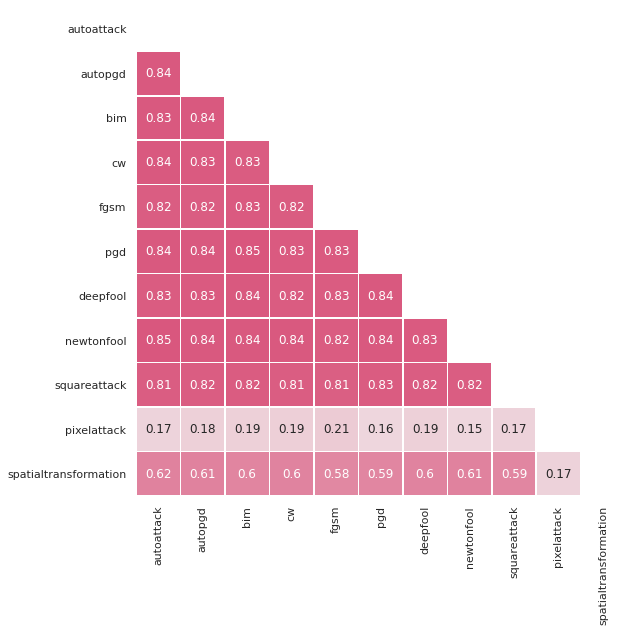

In [14]:
def plot_half_heatmap(data, cmap, path) :
    sns.set_theme(style="white")

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(data, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 9))

    # Draw the heatmap with the mask and correct aspect ratio
    f = sns.heatmap(data, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar=False, annot=True)
    f.figure.savefig(path, bbox_inches='tight')


# Generate a custom diverging colormap
cmap = sns.diverging_palette(h_neg=240, h_pos=0,s=75, l=50, n=1, as_cmap=True)

path = "plot/rq1-sim.png"

plot_half_heatmap(sim, cmap, path)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


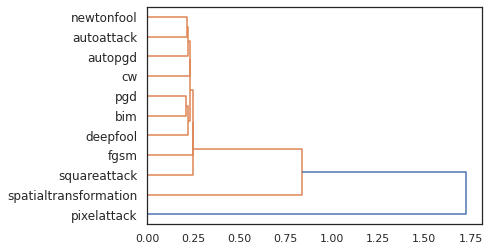

In [15]:
import scipy.cluster.hierarchy as hcluster
linkage = hcluster.linkage(1-sim)
dendro_label = selected_attacks
# dendro_label = sim.columns
dendro  = hcluster.dendrogram(linkage, labels=dendro_label, orientation="right")

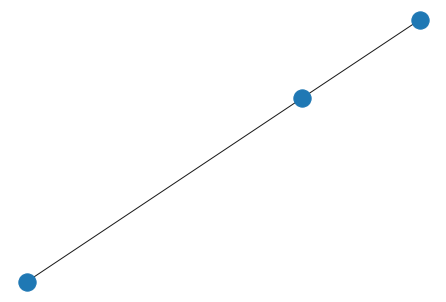

In [16]:
import networkx as nx
G = nx.Graph()
G.add_edge("A", "B")  # default edge data=1
G.add_edge("B", "C", weight=0.1)  # specify edge data

pos = nx.spring_layout(G)  # default to scale=1
nx.draw(G, pos)

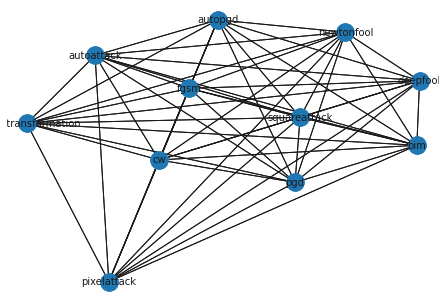

In [17]:
import networkx as nx
G = nx.Graph()

for a1 in attacks: 
    for a2 in attacks :
        G.add_edge(a1, a2, weight=sim[a1][a2])

pos = nx.spring_layout(G)  # default to scale=1
nx.draw(G, pos)
nx.draw(G, pos)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.show() 

In [39]:
attacks = ["autoattack", "autopgd", "bim", "cw", "fgsm", "pgd", "deepfool", "newtonfool", "squareattack", "pixelattack", "spatialtransformation"]

# cluster = ["autoattack", "autopgd", "bim", "cw", "fgsm", "pgd", "deepfool", "newtonfool", "squareattack", "pixelattack"]
# cluster = ["autoattack", "autopgd", "bim", "cw", "fgsm", "pgd", "deepfool", "newtonfool", "squareattack"]
# cluster = ["autoattack", "autopgd", "bim", "pgd"]
cluster = ["pixelattack", "spatialtransformation"]

def get_centroid(cluster, sim) :
    val = {}
    for c in cluster :
        val[c] = 0
        for c2 in cluster :
            val[c] += sim[c][c2]
    max_dist = val[cluster[0]]
    idx = cluster[0]
    for c in cluster :
#         print(c, ": ", val[c])
        if val[c] > max_dist :
            max_dist = val[c]
            idx = c
    return idx
            
get_centroid(cluster, sim)

'pixelattack'

In [19]:
## Example from
# https://stackoverflow.com/questions/53194672/sklearn-dbscan-cosine-vs-precomputed

from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy import sparse

def cluster(X, metric="cosine"):
    cluster = DBSCAN(
        eps=0.5,
        min_samples=3,
        metric=metric,
        algorithm="brute"
    )

    cluster.fit_predict(X)

    return cluster

sentences = [
    "annuler ma commande",
    "commande à annuler",
    "merci de bien vouloir annuler ma commande",
    "produits cassés",
    "mes produits sont cassés",
    "ma commande de produits cassés"
]

vectorizer = TfidfVectorizer()
tfidfs = vectorizer.fit_transform(sentences)
distance_matrix = pairwise_distances(tfidfs, tfidfs, metric='cosine')

doc_id_to_cluster_1 = cluster(tfidfs, "cosine").labels_
doc_id_to_cluster_2 = cluster(sparse.csr_matrix(distance_matrix), "precomputed").labels_

print(doc_id_to_cluster_1)
print(doc_id_to_cluster_2)

[0 0 0 1 1 1]
[0 0 0 1 1 1]


/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


In [20]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

def cluster(X, metric="cosine"):
    cluster = DBSCAN(
        eps=0.2,
        min_samples=1,
        metric=metric,
        algorithm="brute"
    )

    cluster.fit_predict(X)

    return cluster

labels = cluster(1-sim, "precomputed").labels_

print("Label :", labels)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(1-sim, labels))

Label : [0 0 0 0 0 0 0 0 0 1 2]
Silhouette Coefficient: 0.584


In [21]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(affinity="precomputed", linkage='average')
labels = cluster.fit_predict(1-sim)

print("Label :", labels)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(1-sim, labels))

Label : [0 0 0 0 0 0 0 0 0 1 0]
Silhouette Coefficient: 0.748


In [22]:
from sklearn.cluster import AffinityPropagation

cluster = AffinityPropagation(affinity="precomputed")
labels = cluster.fit_predict(1-sim)

print("Label :", labels)
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(1-sim, labels))

Label : [0 0 0 0 0 0 0 0 0 0 0]


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)


In [34]:
def get_cluster(labels, attacks) :
    cls = {}
    for l, a in zip(labels, attacks) :
        if l not in cls.keys() :
            cls[l] = []
        cls[l].append(a)
    return cls

get_cluster(labels, attacks)

{4: ['autoattack', 'newtonfool'],
 8: ['autopgd'],
 3: ['bim', 'pgd'],
 0: ['cw'],
 5: ['fgsm'],
 7: ['deepfool'],
 6: ['squareattack'],
 1: ['pixelattack'],
 2: ['spatialtransformation']}

In [41]:
def get_centroids(clusters) :
    cs = {}
    for k in clusters.keys() :
        cs[k] = get_centroid(clusters[k], sim)
    return cs

get_centroids(get_cluster(labels, sim))

{4: 'autoattack',
 8: 'autopgd',
 3: 'bim',
 0: 'cw',
 5: 'fgsm',
 7: 'deepfool',
 6: 'squareattack',
 1: 'pixelattack',
 2: 'spatialtransformation'}

In [42]:
from sklearn.cluster import KMeans

for i in range(2, 10) :
    kmeans = KMeans(n_clusters=i, random_state=0).fit(accuracies)
    labels = kmeans.labels_
    print()
    print("N cluster : ", i)
    print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(accuracies, labels))
    print("Label : ", labels)
    print("Cluster : ", get_cluster(labels, attacks))
    print("Centroid : ", get_centroids(get_cluster(labels, attacks)))



N cluster :  2
Silhouette Coefficient: 0.313
Label :  [0 0 0 0 0 0 0 0 0 1 1]
Cluster :  {0: ['autoattack', 'autopgd', 'bim', 'cw', 'fgsm', 'pgd', 'deepfool', 'newtonfool', 'squareattack'], 1: ['pixelattack', 'spatialtransformation']}
Centroid :  {0: 'pgd', 1: 'pixelattack'}

N cluster :  3
Silhouette Coefficient: 0.239
Label :  [0 0 0 0 0 0 0 0 0 1 2]
Cluster :  {0: ['autoattack', 'autopgd', 'bim', 'cw', 'fgsm', 'pgd', 'deepfool', 'newtonfool', 'squareattack'], 1: ['pixelattack'], 2: ['spatialtransformation']}
Centroid :  {0: 'pgd', 1: 'pixelattack', 2: 'spatialtransformation'}

N cluster :  4
Silhouette Coefficient: 0.017
Label :  [3 3 0 3 0 0 0 3 0 1 2]
Cluster :  {3: ['autoattack', 'autopgd', 'cw', 'newtonfool'], 0: ['bim', 'fgsm', 'pgd', 'deepfool', 'squareattack'], 1: ['pixelattack'], 2: ['spatialtransformation']}
Centroid :  {3: 'autoattack', 0: 'bim', 1: 'pixelattack', 2: 'spatialtransformation'}

N cluster :  5
Silhouette Coefficient: 0.017
Label :  [3 3 0 3 0 0 0 3 4 1 2]
Cl

In [24]:
from sklearn.cluster import AgglomerativeClustering

for i in range(2, 10) :
    cluster = AgglomerativeClustering(n_clusters=i, affinity="manhattan", linkage="average").fit(accuracies)
    labels = cluster.labels_
    print()
    print("N cluster : ", i)
    print("Label : ", labels)
    print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(accuracies, labels))


N cluster :  2
Label :  [0 0 0 0 0 0 0 0 0 1 0]
Silhouette Coefficient: 0.337

N cluster :  3
Label :  [0 0 0 0 0 0 0 0 0 1 2]
Silhouette Coefficient: 0.239

N cluster :  4
Label :  [0 0 0 0 0 0 0 0 3 1 2]
Silhouette Coefficient: 0.025

N cluster :  5
Label :  [0 0 0 0 4 0 0 0 3 1 2]
Silhouette Coefficient: 0.019

N cluster :  6
Label :  [0 0 2 0 4 2 2 0 3 1 5]
Silhouette Coefficient: 0.016

N cluster :  7
Label :  [0 6 2 0 4 2 2 0 3 1 5]
Silhouette Coefficient: 0.013

N cluster :  8
Label :  [2 6 0 7 4 0 0 2 3 1 5]
Silhouette Coefficient: 0.011

N cluster :  9
Label :  [0 6 2 7 4 2 8 0 3 1 5]
Silhouette Coefficient: 0.010


Automatically created module for IPython interactive environment
circles, perplexity=5 in 0.87 sec
circles, perplexity=30 in 0.85 sec
circles, perplexity=50 in 0.91 sec
circles, perplexity=100 in 1 sec


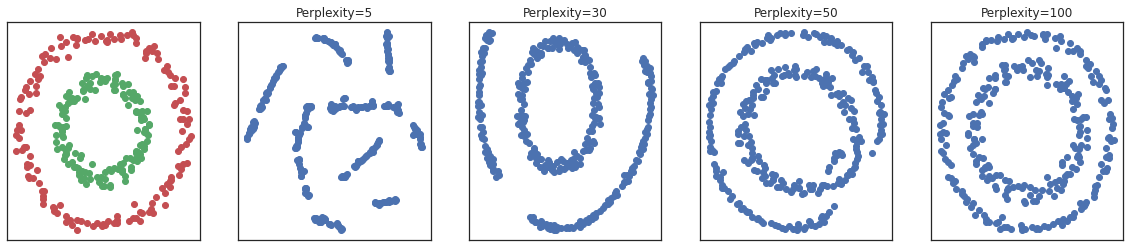

In [25]:
# Author: Narine Kokhlikyan <narine@slice.com>
# License: BSD

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

n_samples = 300
n_components = 2
(fig, subplots) = plt.subplots(1, 5, figsize=(20, 4))
perplexities = [5, 30, 50, 100]

X, y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

red = y == 0
green = y == 1

ax = subplots[0]
ax.scatter(X[red, 0], X[red, 1], c="r")
ax.scatter(X[green, 0], X[green, 1], c="g")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

for i, perplexity in enumerate(perplexities):
    ax = subplots[i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
#     print(Y)
    ax.scatter(Y[:,0], Y[:,1])
#     ax.scatter(Y[red, 0], Y[red, 1], c="r")
#     ax.scatter(Y[green, 0], Y[green, 1], c="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

Automatically created module for IPython interactive environment
circles, perplexity=5 in 0.37 sec
circles, perplexity=10 in 0.35 sec
circles, perplexity=30 in 0.38 sec
circles, perplexity=50 in 0.34 sec
circles, perplexity=100 in 0.37 sec


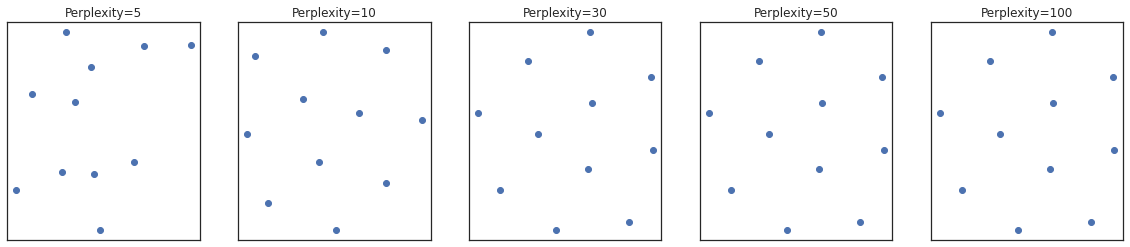

In [26]:
# Author: Narine Kokhlikyan <narine@slice.com>
# License: BSD

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

n_samples = 300
n_components = 2
(fig, subplots) = plt.subplots(1, 5, figsize=(20, 4))
perplexities = [5, 10,  30, 50, 100]

for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(accuracies)
    t1 = time()
    print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:,0], Y[:,1])
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')